In [145]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error, mean_squared_log_error

def weighted_mean_absolute_percentage_error(y_true, y_pred): 
    return np.sum(np.abs((y_true - y_pred) / y_true) * 100 * y_true)/np.sum(y_true)

In [ ]:
import random
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)
os.environ['PYTHONHASHSEED']=str(1)
random.seed(1)

# DATA Overview

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Sale_pred/q1.csv')

In [ ]:
df.head()

,date,cpm
0,2020-07-12,7.781407
1,2020-03-14,7.782481
2,2020-08-03,6.159218
3,2020-07-04,6.600587
4,2020-03-05,6.164228


In [ ]:
df.describe()

,cpm
count,496.000000
mean,7.357426
std,1.955857
min,3.216538
25%,6.145865
50%,7.187659
75%,8.337304
max,19.109299


In [ ]:
df['date'] = pd.to_datetime(df['date'], format='%Y/%m/%d')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496 entries, 0 to 495
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    496 non-null    datetime64[ns]
 1   cpm     496 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 7.9 KB


In [ ]:
df.tail(10)

,date,cpm
486,2020-09-08,6.758004
487,2020-09-09,7.093907
488,2020-09-10,7.916248
489,2020-09-17,9.181000
490,2020-09-18,9.378887
491,2020-09-21,6.717329
492,2020-09-22,7.452210
493,2020-09-23,8.104816
494,2020-09-24,9.229657
495,2020-04-20,4.518594


In [ ]:
df['month'] = pd.to_datetime(df['date']).dt.strftime('%m')

In [ ]:
df['year'] = pd.to_datetime(df['date']).dt.strftime('%y')

In [ ]:
df['day'] = pd.to_datetime(df['date']).dt.strftime('%d')

In [ ]:
df.head()

,date,cpm,month,year,day
0,2019-08-01,6.996545,08,19,01
1,2019-08-02,6.598493,08,19,02
2,2019-08-03,6.381420,08,19,03
3,2019-08-04,6.548243,08,19,04
4,2019-08-05,6.586502,08,19,05


In [ ]:
df.tail()

,date,cpm,month,year,day
490,2020-12-04,11.343935,12,20,04
492,2020-12-05,11.248361,12,20,05
493,2020-12-06,10.281638,12,20,06
488,2020-12-07,6.954836,12,20,07
489,2020-12-08,7.944096,12,20,08


In [ ]:
 df = df.sort_values(by=['year','month','day'])

In [ ]:
df = df.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


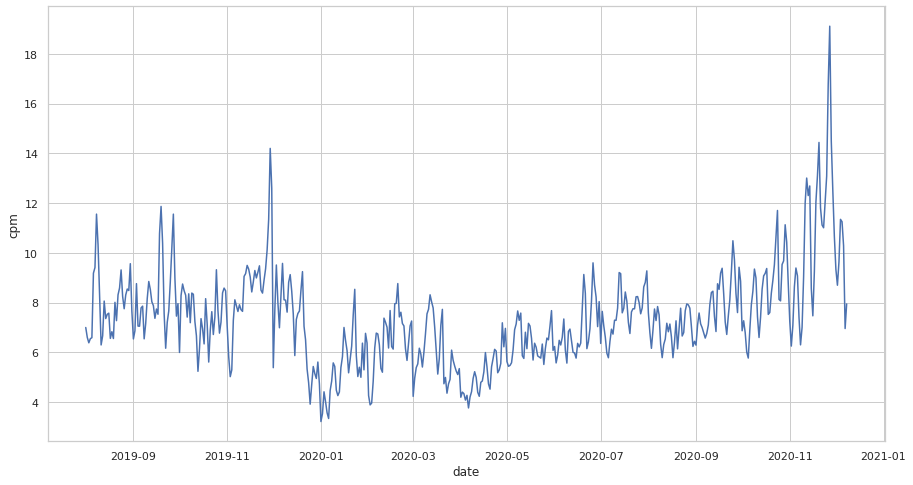

In [ ]:
plt.figure(figsize = (15,8))
sns.set(style='whitegrid')

sns.lineplot(df.date, df.cpm);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


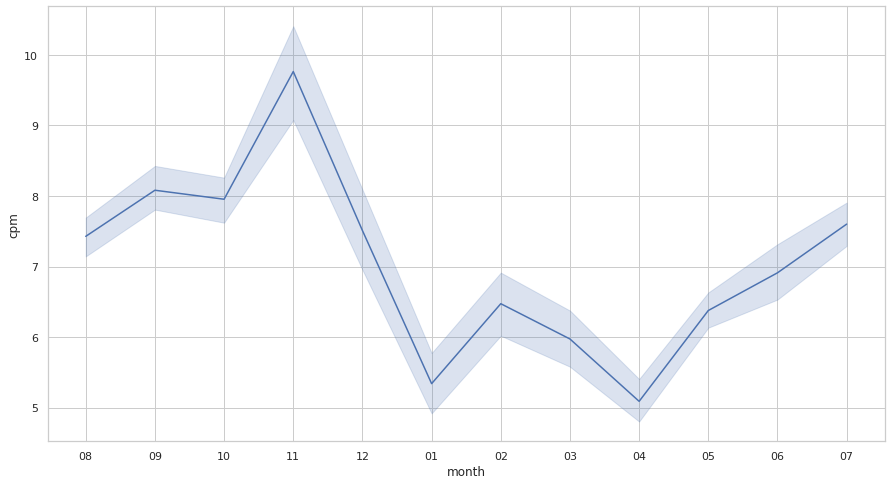

In [ ]:
plt.figure(figsize = (15,8))
sns.set(style='whitegrid')

sns.lineplot(df.month, df.cpm);

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


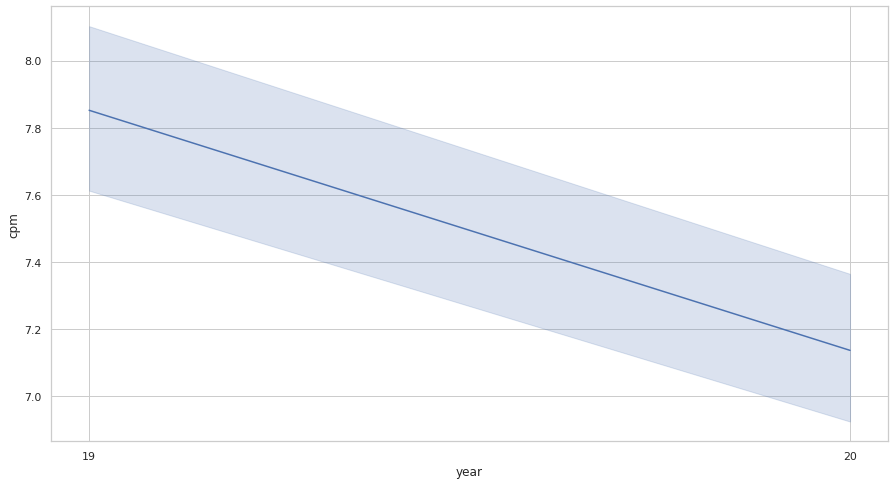

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.set(style='whitegrid')

sns.lineplot(df.year, df.cpm);

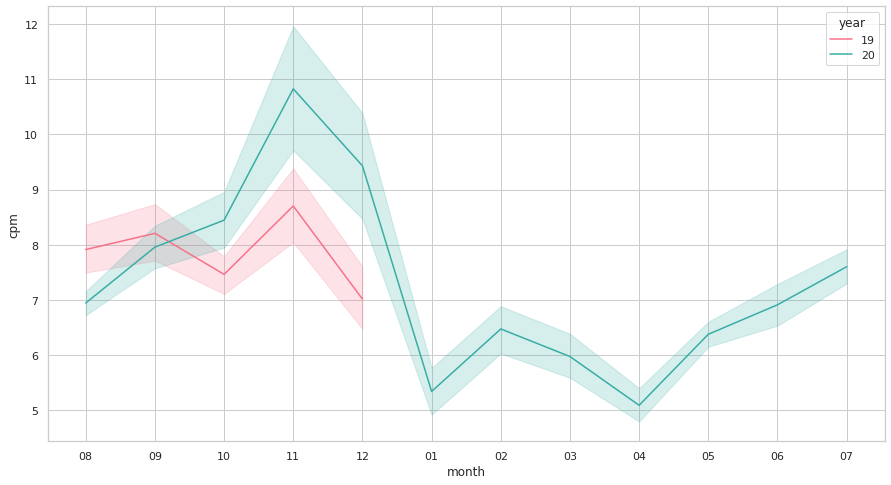

In [ ]:
fig = plt.figure(figsize=(15,8))
sns.set(style='whitegrid')
#plt.style.use('fast')
sns.lineplot(x='month', y='cpm', hue='year',data=df,palette=sns.color_palette("husl", 2));

In [ ]:
def plot_moving_avg(series, window, plot_intervals = False, scale=1.96, plot_anomalies=False):


  """
        series - Total_sell_in (df[['Total_Sell_in']]) 
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

  """
  rolling_mean = series.rolling(window=window).mean()
  plt.figure(figsize=(15,8))
  plt.title("Moving average\n window size = {}".format(window))
  plt.plot(rolling_mean, "r", label="Rolling mean trend")


  # Plot confidence intervals for smoothed values
  if plot_intervals:
    mae = mean_absolute_error(series[window:], rolling_mean[window:])
    deviation = np.std(series[window:] - rolling_mean[window:])
    lower_bond = rolling_mean - (mae + scale * deviation)
    upper_bond = rolling_mean + (mae + scale * deviation)
    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
        
  # Having the intervals, find abnormal values
  if plot_anomalies:
    anomalies = pd.DataFrame(index=series.index, columns=series.columns)
    anomalies[series<lower_bond] = series[series<lower_bond]
    anomalies[series>upper_bond] = series[series>upper_bond]
    plt.plot(anomalies, "ro", markersize=10)
        
  plt.plot(series[window:], label="Actual values")
  plt.legend(loc="upper left")
  plt.grid(True)



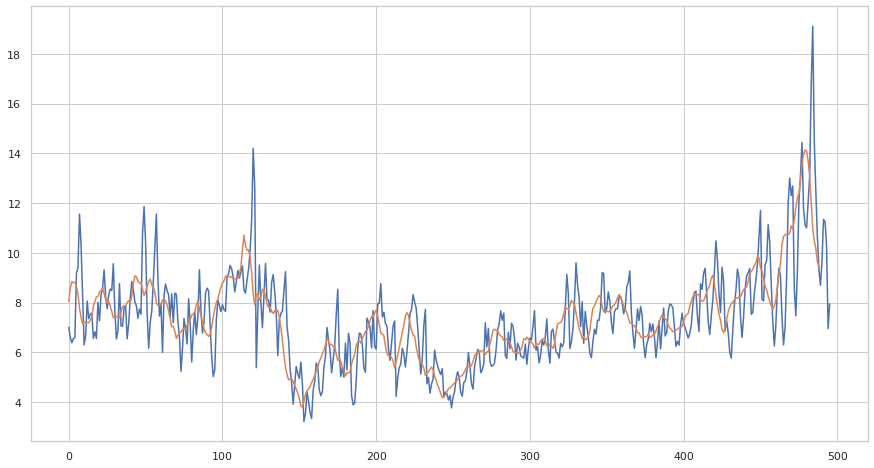

In [ ]:
plt.figure(figsize=(15,8))
plt.plot(df['cpm'].values)
plt.plot(d.values)



In [ ]:
d = df['cpm'].rolling(window=7).mean()
d = d[7:]

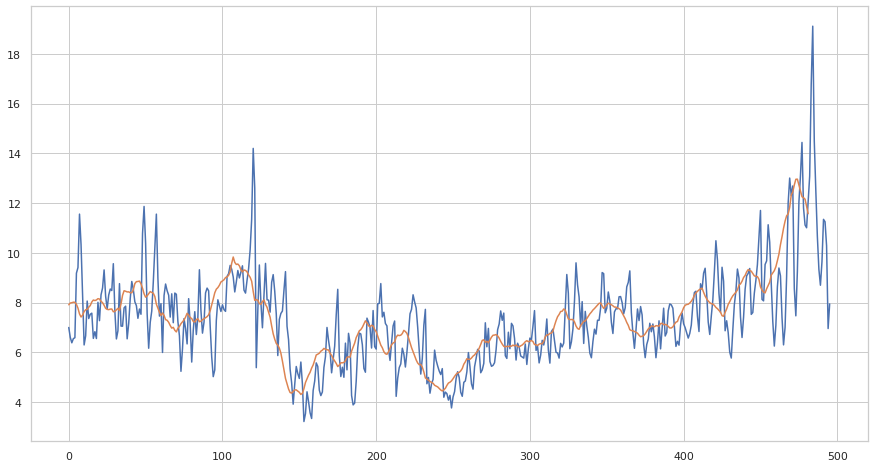

In [ ]:
d = df['cpm'].rolling(window=14).mean()
d = d[14:]
plt.figure(figsize=(15,8))
plt.plot(df['cpm'].values)
plt.plot(d.values)

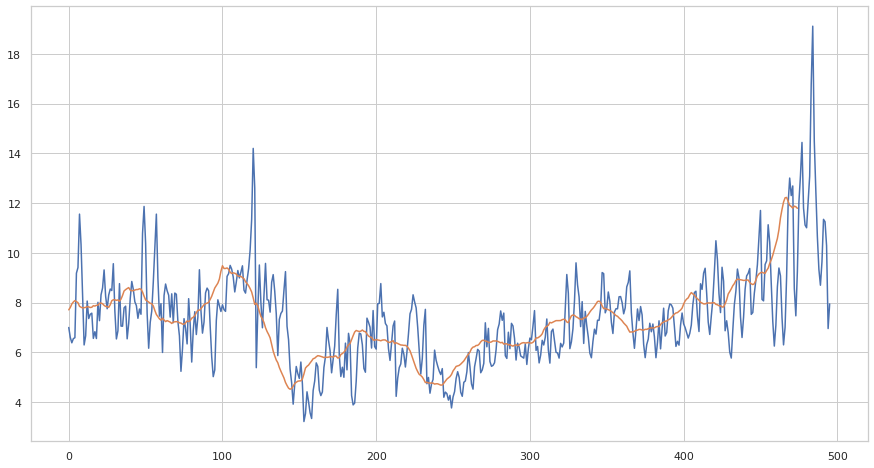

In [ ]:
d = df['cpm'].rolling(window=21).mean()
d = d[21:]
plt.figure(figsize=(15,8))
plt.plot(df['cpm'].values)
plt.plot(d.values)

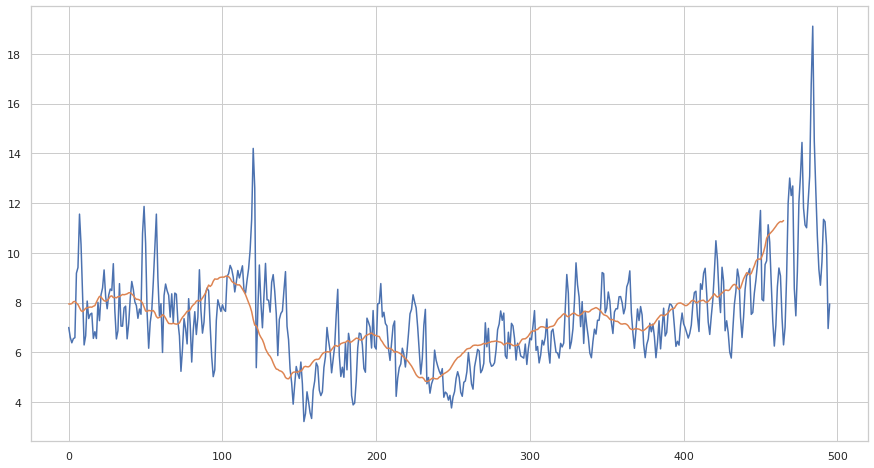

In [ ]:
d = df['cpm'].rolling(window=30).mean()
d = d[30:]
plt.figure(figsize=(15,8))
plt.plot(df['cpm'].values)
plt.plot(d.values)

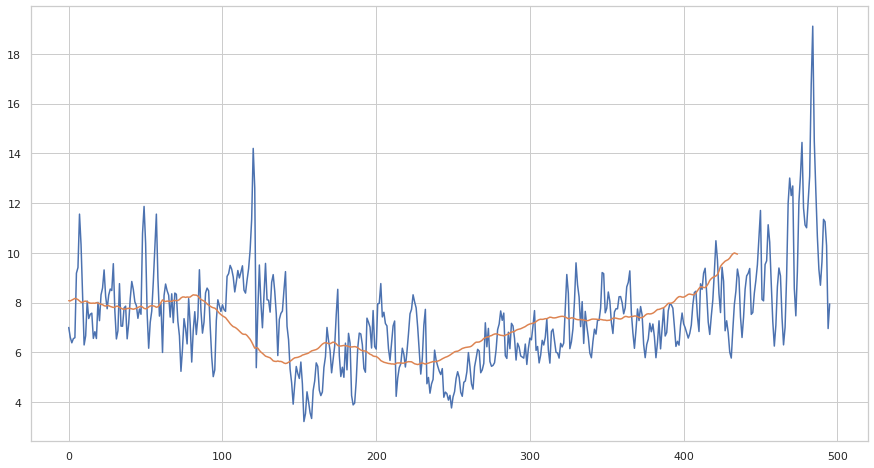

In [ ]:
d = df['cpm'].rolling(window=60).mean()
d = d[60:]
plt.figure(figsize=(15,8))
plt.plot(df['cpm'].values)
plt.plot(d.values)

In [ ]:
result = adfuller(df['cpm'])
print('ADF characteristic', result[0])
print('p-value', result[1])

ADF characteristic -2.2332819669378092
p-value 0.19438847758284028


# MA

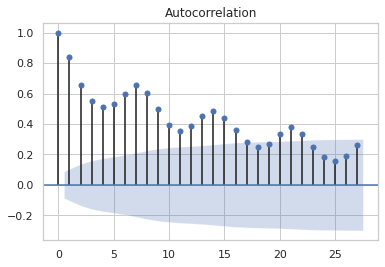

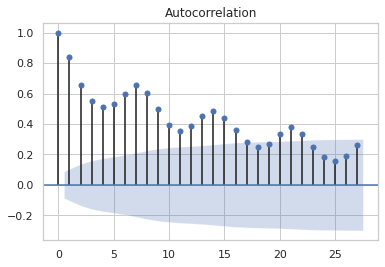

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(df['cpm'])

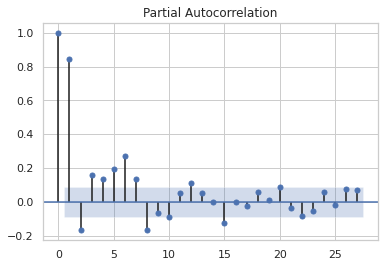

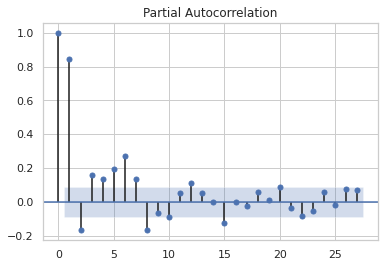

In [ ]:
plot_pacf(df['cpm'])

In [ ]:
df["month"] = pd.to_numeric(df["month"])
df["day"] = pd.to_numeric(df["day"])


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 496 entries, 0 to 489
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    496 non-null    datetime64[ns]
 1   cpm     496 non-null    float64       
 2   month   496 non-null    int64         
 3   year    496 non-null    int64         
 4   day     496 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 23.2 KB


In [ ]:
df['cpm']

0       6.996545
1       6.598493
2       6.381420
3       6.548243
4       6.586502
         ...    
490    11.343935
492    11.248361
493    10.281638
488     6.954836
489     7.944096
Name: cpm, Length: 496, dtype: float64

In [ ]:
diff_1st = df.diff(periods=1)

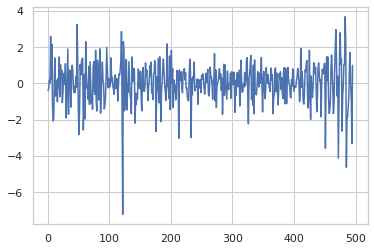

In [ ]:
plt.plot(diff_1st['cpm'].values)

In [ ]:
result = adfuller(diff_1st['cpm'].dropna())
print('ADF characteristic', result[0])
print('p-value', result[1])

ADF characteristic -7.262498438548053
p-value 1.6673891057035625e-10


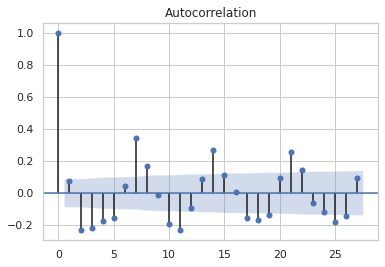

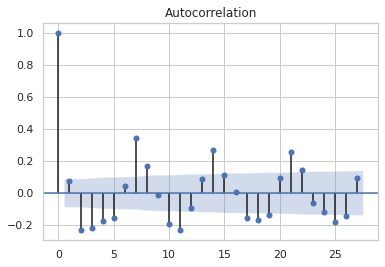

In [ ]:
plot_acf(diff_1st['cpm'][1:])

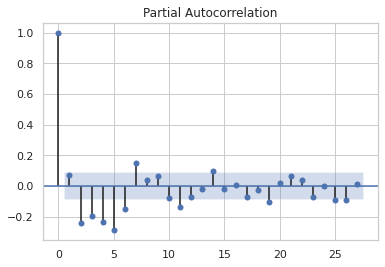

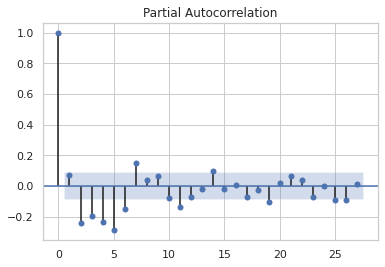

In [ ]:
plot_pacf(diff_1st['cpm'][1:])

In [ ]:
diff_1st


,date,cpm,month,year,day
0,NaT,NaN,NaN,NaN,NaN
1,1 days,-0.398052,0.0,0.0,1.0
2,1 days,-0.217073,0.0,0.0,1.0
3,1 days,0.166823,0.0,0.0,1.0
4,1 days,0.038259,0.0,0.0,1.0
...,...,...,...,...,...
490,1 days,1.703417,0.0,0.0,1.0
492,1 days,-0.095574,0.0,0.0,1.0
493,1 days,-0.966723,0.0,0.0,1.0
488,1 days,-3.326802,0.0,0.0,1.0


# Arima

In [ ]:
train_df=df[:347]
test_df=df[347:]

In [162]:
arimax = SARIMAX(train_df['cpm'], order=(5,1,5))
arimax = arimax.fit(disp=False)
pred = arimax.predict(347,495)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


In [163]:
weighted_mean_absolute_percentage_error(test_df['cpm'], pred)

18.602281432846077

In [ ]:
from itertools import product                    
from tqdm import tqdm_notebook

In [ ]:
p = range(0, 8)
d= range(0,3)
q = range(0, 8)



parameters = product(p,d,q)
parameters_list = list(parameters)
len(parameters_list)

192

In [ ]:
def optimizeARIMA(parameters_list):
  
    
    results = []
    best_aic = np.inf
    best_model = None
    best_param =None

    for param in tqdm_notebook(parameters_list):
        
        try:
            model=SARIMAX(train_df['cpm'], order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
            continue
        aic = model.aic

        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table,best_param,best_model,best_aic

In [ ]:
table, param, model, aic, =optimizeARIMA(parameters_list)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:215: ValueWarning: An unsupported index was pro

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [ ]:
table

,parameters,aic
0,"(4, 1, 6)",925.465593
1,"(5, 1, 5)",926.909189
2,"(4, 1, 7)",927.253822
3,"(2, 1, 4)",927.409300
4,"(5, 1, 6)",927.584873
...,...,...
187,"(0, 0, 4)",1403.647780
188,"(0, 0, 3)",1479.248437
189,"(0, 0, 2)",1643.255981
190,"(0, 0, 1)",1928.078729


In [172]:
df['Arima_pred'] = arimax.predict(0,495)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


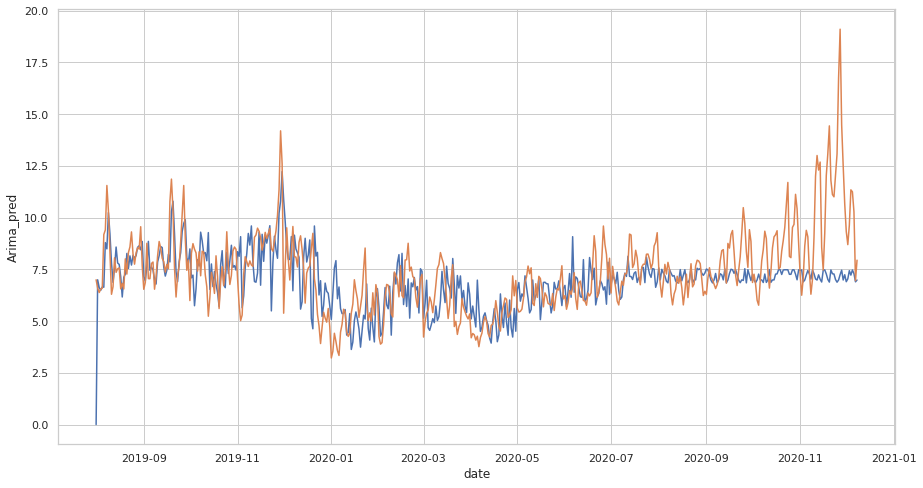

In [173]:
plt.figure(figsize = (15,8))
sns.set(style='whitegrid')
sns.lineplot('date','Arima_pred',data=df)
sns.lineplot('date', 'cpm', data=df)


In [174]:
df

,date,cpm,month,year,day,Arima_pred
0,2019-08-01,6.996545,8,19,1,0.000000
1,2019-08-02,6.598493,8,19,2,6.996545
2,2019-08-03,6.381420,8,19,3,6.623091
3,2019-08-04,6.548243,8,19,4,6.490013
4,2019-08-05,6.586502,8,19,5,6.649975
...,...,...,...,...,...,...
490,2020-12-04,11.343935,12,20,4,7.222371
492,2020-12-05,11.248361,12,20,5,7.468865
493,2020-12-06,10.281638,12,20,6,7.293052
488,2020-12-07,6.954836,12,20,7,6.899082


In [178]:
from fbprophet import Prophet


In [ ]:
d = df.copy()
d = d.rename(columns={'date':'ds', 'cpm':'y'})

In [176]:
prophet_df = train_df
prophet_df = prophet_df.rename(columns={'date':'ds', 'cpm':'y'})

In [179]:
m = Prophet()
m = m.fit(prophet_df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [180]:
future = m.make_future_dataframe(periods =149)
forecast = m.predict(future)


In [181]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-08-01,8.254601,7.059461,10.490869,8.254601,8.254601,0.542797,0.542797,0.542797,0.542797,0.542797,0.542797,0.0,0.0,0.0,8.797398
1,2019-08-02,8.246894,7.210169,10.439848,8.246894,8.246894,0.643955,0.643955,0.643955,0.643955,0.643955,0.643955,0.0,0.0,0.0,8.890848
2,2019-08-03,8.239187,6.631000,9.951323,8.239187,8.239187,0.073208,0.073208,0.073208,0.073208,0.073208,0.073208,0.0,0.0,0.0,8.312395
3,2019-08-04,8.231480,5.965999,9.336083,8.231480,8.231480,-0.652271,-0.652271,-0.652271,-0.652271,-0.652271,-0.652271,0.0,0.0,0.0,7.579209
4,2019-08-05,8.223773,5.945570,9.116929,8.223773,8.223773,-0.653832,-0.653832,-0.653832,-0.653832,-0.653832,-0.653832,0.0,0.0,0.0,7.569941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
491,2020-12-04,8.801415,7.614483,11.112332,8.159542,9.410258,0.643955,0.643955,0.643955,0.643955,0.643955,0.643955,0.0,0.0,0.0,9.445370
492,2020-12-05,8.814327,7.055918,10.642428,8.166441,9.431154,0.073208,0.073208,0.073208,0.073208,0.073208,0.073208,0.0,0.0,0.0,8.887535
493,2020-12-06,8.827240,6.409926,10.052570,8.170677,9.452049,-0.652271,-0.652271,-0.652271,-0.652271,-0.652271,-0.652271,0.0,0.0,0.0,8.174969
494,2020-12-07,8.840152,6.460829,9.924873,8.172932,9.471063,-0.653832,-0.653832,-0.653832,-0.653832,-0.653832,-0.653832,0.0,0.0,0.0,8.186320


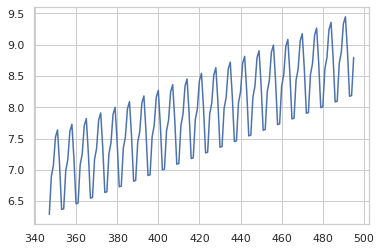

In [182]:
plt.plot(forecast['yhat'][347:])

In [183]:
df['fb_prophet'] = forecast['yhat']

# LSTM

In [184]:
def data_prep(sequence, n_steps):
  X, y = list(), list()
  for i in range(len(sequence)):

    end_ix = i+n_steps
    if end_ix >= len(sequence):
      break

    seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
    X.append(seq_x)
    y.append(seq_y)

  return np.array(X), np.array(y)


In [185]:
def predictions(data, n_steps):
  pred=[]

  for i in range(0,len(data)):
    end_idx = i+n_steps
    if end_idx >= len(data):
      break
    X = data[i:end_idx]
    X = X.reshape(1,n_steps,1)
    pred.append(model.predict(X, verbose=0))
  return np.array(pred)

In [186]:
data = df['cpm'][0:347].values

In [187]:

n_steps = 7
X, y = data_prep(data, n_steps)
n_features=1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [188]:
model = Sequential()
model.add(LSTM(150, activation='relu',return_sequences=True, input_shape = (n_steps,n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [189]:
model.fit(X,y, epochs=1000)

Epoch 1/1000
11/11 [==============================] - 0s 15ms/step - loss: 40.2998
Epoch 2/1000
11/11 [==============================] - 0s 15ms/step - loss: 9.6095
Epoch 3/1000
11/11 [==============================] - 0s 14ms/step - loss: 6.5716
Epoch 4/1000
11/11 [==============================] - 0s 14ms/step - loss: 3.5522
Epoch 5/1000
11/11 [==============================] - 0s 14ms/step - loss: 2.2707
Epoch 6/1000
11/11 [==============================] - 0s 14ms/step - loss: 1.8370
Epoch 7/1000
11/11 [==============================] - 0s 14ms/step - loss: 1.4873
Epoch 8/1000
11/11 [==============================] - 0s 14ms/step - loss: 1.3882
Epoch 9/1000
11/11 [==============================] - 0s 14ms/step - loss: 1.2983
Epoch 10/1000
11/11 [==============================] - 0s 15ms/step - loss: 1.3610
Epoch 11/1000
11/11 [==============================] - 0s 17ms/step - loss: 1.3112
Epoch 12/1000
11/11 [==============================] - 0s 15ms/step - loss: 1.2507
Epoch 13/100

In [202]:
x_test = df['cpm'][340:].values

In [203]:
pred = predictions(x_test,7)

In [205]:
pred = pred.reshape(len(pred))

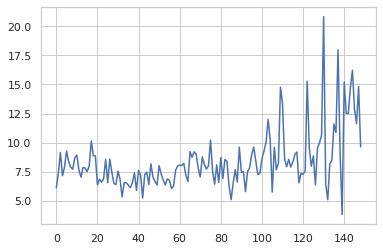

In [207]:
plt.plot(pred)

In [197]:
train_pred = predictions(df['cpm'][0:347].values,7)
train_pred = train_pred.reshape(len(train_pred))

In [199]:
len(train_pred)

340

In [200]:
df.head(7)

,date,cpm,month,year,day,Arima_pred,fb_prophet
0,2019-08-01,6.996545,8,19,1,0.000000,8.797398
1,2019-08-02,6.598493,8,19,2,6.996545,8.890848
2,2019-08-03,6.381420,8,19,3,6.623091,8.312395
3,2019-08-04,6.548243,8,19,4,6.490013,7.579209
4,2019-08-05,6.586502,8,19,5,6.649975,7.569941
5,2019-08-06,9.181622,8,19,6,6.638010,8.157639
6,2019-08-07,9.407133,8,19,7,8.793763,8.312928


In [ ]:
d = [6.996545,6.598493,]

In [206]:
weighted_mean_absolute_percentage_error(test_df['cpm'], pred)

17.07344117342504

In [211]:
d = df['cpm'][0:7].values
d = list(d)

In [213]:
d.extend(list(train_pred)+list(pred))

In [214]:
df['lstm_7d'] = d

In [216]:
df.head(10)

,date,cpm,month,year,day,Arima_pred,fb_prophet,lstm_7d
0,2019-08-01,6.996545,8,19,1,0.000000,8.797398,6.996545
1,2019-08-02,6.598493,8,19,2,6.996545,8.890848,6.598493
2,2019-08-03,6.381420,8,19,3,6.623091,8.312395,6.381420
3,2019-08-04,6.548243,8,19,4,6.490013,7.579209,6.548243
4,2019-08-05,6.586502,8,19,5,6.649975,7.569941,6.586502
5,2019-08-06,9.181622,8,19,6,6.638010,8.157639,9.181622
6,2019-08-07,9.407133,8,19,7,8.793763,8.312928,9.407133
7,2019-08-08,11.554850,8,19,8,8.490416,8.743449,11.449838
8,2019-08-09,10.331497,8,19,9,10.244949,8.836899,10.272537
9,2019-08-10,8.261345,8,19,10,9.208990,8.258445,8.077076


In [217]:
df.to_csv('model_pred.csv')

# lstm_14

In [218]:
data = df['cpm'][0:347].values

In [ ]:

n_steps = 7
X, y = data_prep(data, n_steps)
n_features=1
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [ ]:
mape = keras.losses.MeanAbsolutePercentageError()

In [ ]:
model = Sequential()
model.add(LSTM(150, activation='relu',return_sequences=True, input_shape = (n_steps,n_features)))
model.add(LSTM(50, activation='relu'))

model.add(Dense(1))
model.compile(optimizer='adam', loss=mape)